# Main ideas and Motivation

- This notebook brings a careful preparation/feature engineering of
the ENEM data for a classification problem where one is looking to identify
whether a candidate will be above the or below the mean based on the social
information.

-The first idea would be to carry out the investigation for all the five
subjects of the ENEM test, however, I am pretty satisfied with the stuff that I have handled/learned
in this project so far, so I decided to stop working on it. However, as a message
for the future (if I decided to come back to it): after carefully taking care of the
data, it seems not much relevant what kind of classification model is used, a
better feature engineering is necessary. The main ideas regarding the latter is
the creation of two to three "social grades" based on the information given by the
candidate and assign different weights to them (like those which are directly related to income
and those that don't).

- I have worked with four algorithms here: Logistic Regression, Random Forest,
XGBoost and LightGBM, where the last two I have done an in-depth hyparameter tunning.


- My main motivation for this project is: since I came from a state public school
in Rio de Janeiro and with a higher degree on hands, I wanted to better understand
the real relevance of social level/status in education access of the students. Also,
as a Physicist/scientist, I believe that Brazil is going through a serious Scientific
crisis, from the economical and social point of view. The highest power of the republic
is taking (or at least trying to take) actions which is totally against scientific measures,
and [according to specialists](https://www.youtube.com/watch?v=A1roAHtuTPQ) 
this might lead to severe problems related to gene mutation. Therefore, I believe that 
we need to seriously make people aware about scientific research.

- One of the criticism that I took is that I should turn my work onto something
value and try to extract impact from it. Regarding that, I managed to have a model's
performance improvement of $1.2\%$ on the classification of students/applicants
which were below or above the mean in natural sciences in $2018$. Although it is a small
number, I decided to check the relevance of this $1.2\%$ in a Gedanken experiment of:
hiring more teachers for public schools in natural sciences (Physics, Chemistry and Biology),
for helping those students which have a bigger chance of scoring below the mean.
In a cycle of three years, this $1.2\%$ reflects in an up to $128$ millions in Brazilian
reais that can be saved by correcting classifying the students. Although that is a small
value compared to the Brazilian GNP this money could be used in different ways, for example:

For the federal government, according to the [UNICAMP website](https://www.unicamp.br/unicamp/coronavirus/quanto-custa), $128\cdot10^6$ is equivalent to:

- Test almost 1.9 million Brazilian people for COVID-19;
- Implantation of a little over 700 ICU rooms;
- For attending 1000 ICU rooms for COVID-patients, it costs $207000R\$$ in medical supplies.
One could mantain these ICU for almost two years.

Also, related to the education per se, it is informed that during 2020 [$143.3$](https://g1.globo.com/educacao/noticia/2021/02/21/ministerio-da-educacao-nao-gasta-o-dinheiro-que-tem-disponivel-e-sofre-reducao-de-recursos-em-2020-aponta-relatorio.ghtml)
billions Brazilian reais was reserved to the education. Accordingly to our value, that is approximatelly
$0.01\%$ of the total income used in the entire education in the country.

Another interesting example regarding education, according to [this news](https://g1.globo.com/educacao/noticia/2019/09/02/capes-deixa-de-oferecer-5613-bolsas-a-partir-deste-mes-e-preve-economia-de-r-544-milhoes-em-4-anos.ghtml)
the federal funding agency was planning to cancel 5.613 scholarships for PhD
and Master researchers and that would allow them to save 544 millions in Brazilian reais
in four years, which corresponds to 136 millions in one year. Our calculation basic
improvement shows a saving of 32 millions per year, which corresponds to roughly $25\%$
of this value.

# Content

* [Data cleaning](#data_cleaning)
* [Ordering some categorical features](#ordering_categorical)
* [Logistic Regression model](#logistic_regression)
* [Different thresholds for the Logistic Regression](#diff_thresholds_lr)
* [Random Forest classifier](#rf)
    * [Feature importance (FI) discussion](#rf_feat_imp)
    * [New FI after removing some features that were blurring the model](#rf_feat_imp2)
* [XGBoost Classifier and hyperparameter tuning](#xgb_classifier)
* [LightGBM Classifier](#lgbm)
    * [FI using LightGBM](#fi_lgbm)
    * [Partial conclusion about lightgbm and previous models](#partial_conclusion)
    * [Investigating different thresholds](#diff_th_lgbm)
* [Final Conclusion about the Classification problem and understanding the improvement](#final_conc)
* [Different analysis that could have been done](#diff_path)<a id='diff_path'></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

from pickle import dump

warnings.filterwarnings('ignore')


pd.options.display.float_format = "{:,.2f}".format

In [2]:
df2018 = pd.read_csv('DADOS/MICRODADOS_ENEM_2018.csv',
                     nrows = 100000, sep = ';', encoding = 'ISO-8859-1')


df2018.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180008202043,2018,5300108,Brasília,53,DF,44.00,M,1.00,1,...,A,A,A,A,A,A,A,A,B,A
1,180007197856,2018,2111102,São João dos Patos,21,MA,23.00,F,0.00,3,...,A,B,A,A,B,A,A,A,A,A
2,180008517434,2018,3530607,Mogi das Cruzes,35,SP,23.00,F,0.00,1,...,A,B,A,A,B,B,B,B,A,A
3,180007661228,2018,2916401,Itapetinga,29,BA,26.00,F,0.00,3,...,A,B,B,A,C,A,B,B,A,A
4,180008787987,2018,2918100,Jeremoabo,29,BA,20.00,M,0.00,0,...,A,B,A,A,B,A,B,B,B,A


## Data cleaning

<a id='data_cleaning'></a>

### Removing some irrelevant columns

Some columns can be seen directly as been irrelevant for us, the first of them is
the enrollment number, since we are interested in the social information and this
is an individual number to each applicant. Another one is the NU_ANO, since it
corresponds to the year of the specific national exam. Also 'CO_MUNICIPIO_RESIDENCIA'
is equivalent to 'NO_MUNICIPIO_RESIDENCIA' and 'CO_UF_RESIDENCIA' is equivalent to 'SG_UF_RESIDENCIA'.

In [3]:
cols = ['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'TP_NACIONALIDADE', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO']

df2018 = df2018.drop(columns = cols)

df2018.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,Brasília,DF,44.00,M,1.00,1,2,0,2,1.00,...,A,A,A,A,A,A,A,A,B,A
1,São João dos Patos,MA,23.00,F,0.00,3,1,5,1,1.00,...,A,B,A,A,B,A,A,A,A,A
2,Mogi das Cruzes,SP,23.00,F,0.00,1,1,3,1,3.00,...,A,B,A,A,B,B,B,B,A,A
3,Itapetinga,BA,26.00,F,0.00,3,1,8,1,1.00,...,A,B,B,A,C,A,B,B,A,A
4,Jeremoabo,BA,20.00,M,0.00,0,2,0,2,1.00,...,A,B,A,A,B,A,B,B,B,A


For the model prediction, we are also not interested in information regarding the answers
given by the students at the answer card. Nor the test informations, like the test number and so on

In [4]:
cols = ['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'TX_GABARITO_CN',
        'TX_GABARITO_CH', 'TX_GABARITO_LC','TX_GABARITO_MT','TP_STATUS_REDACAO',
        'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

df2018 = df2018.drop(columns = cols)

### Analyzing absent applicants

The columns containing "PRESENCA" in the name, tells us when the applicants were present 
or not in the test. Let's analyze this and also remove those applicants which were absent

In [5]:
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

## Removing those which didn't show up for the test

df2018 = df2018[(df2018.TP_PRESENCA_CN == 1) & (df2018.TP_PRESENCA_CH == 1) & (df2018.TP_PRESENCA_LC == 1) & (df2018.TP_PRESENCA_MT == 1)]

print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

26932
73051
15
0
72936
0


### Analyzing the nan-values

In [6]:
df2018.drop(columns = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'], inplace = True)

In [7]:
print(df2018.iloc[:, : 60].isna().sum())
print(df2018.iloc[:, 60: 120].isna().sum())
print(df2018.iloc[:, 120: ].isna().sum())

NO_MUNICIPIO_RESIDENCIA            0
SG_UF_RESIDENCIA                   0
NU_IDADE                           1
TP_SEXO                            0
TP_ESTADO_CIVIL                 2562
TP_COR_RACA                        0
TP_ST_CONCLUSAO                    0
TP_ANO_CONCLUIU                    0
TP_ESCOLA                          0
TP_ENSINO                      18093
IN_TREINEIRO                       0
CO_ESCOLA                      55628
CO_MUNICIPIO_ESC               55628
NO_MUNICIPIO_ESC               55628
CO_UF_ESC                      55628
SG_UF_ESC                      55628
TP_DEPENDENCIA_ADM_ESC         55628
TP_LOCALIZACAO_ESC             55628
TP_SIT_FUNC_ESC                55628
IN_BAIXA_VISAO                     0
IN_CEGUEIRA                        0
IN_SURDEZ                          0
IN_DEFICIENCIA_AUDITIVA            0
IN_SURDO_CEGUEIRA                  0
IN_DEFICIENCIA_FISICA              0
IN_DEFICIENCIA_MENTAL              0
IN_DEFICIT_ATENCAO                 0
I

In [8]:
## Let's start by analyzing the following set of columns

df2018[['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
        'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC']].head()

,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"23,077,140.00","2,304,400.00",Fortaleza,23.00,CE,2.00,1.00,1.00
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These columns represent most likely the same information (city and state).
However, since most of the high school students study on their own hometown,
for most people these information do not bring any extra information .
Since most of them are nan-values, let's simply drop them out.

In [9]:
df2018.drop(columns = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
                       'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
                       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC'], inplace = True)

In [10]:
print(df2018.iloc[:, : 15].isna().sum())

NO_MUNICIPIO_RESIDENCIA        0
SG_UF_RESIDENCIA               0
NU_IDADE                       1
TP_SEXO                        0
TP_ESTADO_CIVIL             2562
TP_COR_RACA                    0
TP_ST_CONCLUSAO                0
TP_ANO_CONCLUIU                0
TP_ESCOLA                      0
TP_ENSINO                  18093
IN_TREINEIRO                   0
IN_BAIXA_VISAO                 0
IN_CEGUEIRA                    0
IN_SURDEZ                      0
IN_DEFICIENCIA_AUDITIVA        0
dtype: int64


The column *TP_ENSINO* corresponds to the kind of school that
the student has came from, *i.e.*, regular schools (1), high school
done in a shorter time (2) and schools for adults (3). We can take a look
on their kind of school and their age to analyse its nan-values and fill
at least some of them with some guessing.

In [11]:
# Okay, there a bunch of people younger than 17-18 (which is
#the age that most people are finishing their high schools), so for
#these people we can fill up with regular school right away

df2018[['NU_IDADE', 'TP_ENSINO']][df2018.TP_ENSINO.isna()].head(10)

,NU_IDADE,TP_ENSINO
22,29.00,NaN
27,19.00,NaN
31,16.00,NaN
59,16.00,NaN
122,15.00,NaN
174,18.00,NaN
193,19.00,NaN
203,41.00,NaN
230,18.00,NaN
239,19.00,NaN


In [12]:
cond = (df2018.TP_ENSINO.isna()) & (df2018.NU_IDADE <= 20)

df2018.loc[cond] = df2018.loc[cond].fillna(1)

df2018.TP_ENSINO.value_counts(dropna = False)

1.00    60190
NaN      8107
3.00     4355
2.00      284
Name: TP_ENSINO, dtype: int64

The rest of nan-values probably lie within the groups 2 or 3.
However the data is pretty unbalanced and we might join the groups
2 and 3 together later on.

In [13]:
df2018.TP_ENSINO = df2018.TP_ENSINO.fillna(2)

print(df2018.iloc[:, : 10].isna().sum())

NO_MUNICIPIO_RESIDENCIA       0
SG_UF_RESIDENCIA              0
NU_IDADE                      1
TP_SEXO                       0
TP_ESTADO_CIVIL            2394
TP_COR_RACA                   0
TP_ST_CONCLUSAO               0
TP_ANO_CONCLUIU               0
TP_ESCOLA                     0
TP_ENSINO                     0
dtype: int64


### Analyzing the marital status of the applicants

In [14]:
## Again, even filling the nan-values properly, it won't help that much
## due to unbalanced data. Therefore we will split it later on single and non-single people

df2018.TP_ESTADO_CIVIL.value_counts(dropna = False)

0.00    63740
1.00     5842
NaN      2394
2.00      908
3.00       52
Name: TP_ESTADO_CIVIL, dtype: int64

In [15]:
cond = (df2018.TP_ESTADO_CIVIL.isna()) & (df2018.NU_IDADE <= 25)
cols = ['TP_ESTADO_CIVIL', 'NU_IDADE']

df2018.loc[cond, cols] = df2018.loc[cond, cols].fillna(0)

df2018.TP_ESTADO_CIVIL = df2018.TP_ESTADO_CIVIL.fillna(1)

In [16]:
# Filling the missing data related to age

df2018.NU_IDADE = df2018.NU_IDADE.fillna(round(df2018.NU_IDADE.mean()))

print(df2018.iloc[:, : 6].isna().sum())

NO_MUNICIPIO_RESIDENCIA    0
SG_UF_RESIDENCIA           0
NU_IDADE                   0
TP_SEXO                    0
TP_ESTADO_CIVIL            0
TP_COR_RACA                0
dtype: int64


### Dealing with the students which scored zero in the essay

When someone scores zero in the essay this applicant will not be able to enroll
most of the universties. Therefore, it is safe to drop them out. Let's investigate

In [17]:
print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

## If someone scored 0 at the essay it won't be accept in most
## of the universities. So we will drop this candidate
df2018 = df2018[df2018.NU_NOTA_REDACAO != 0]

print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

1046
0


In [18]:
# Checking those students which were present in the tests



## Some feature engineering

There are some information which are not particularly relevant due to how unbalanced is the data in some features.
One of them is the marital status. Most people applying is single and the rest is divided into three categories.
Might be useful to create:
- Single (1) not single (0) instead of marital status.
- Regarding the city, it might be worth checking whether the applicant lives in the capital or not.

In [19]:
## Creating the capital information

state_capitals = ['Rio Branco', 'Macapá', 'Manaus', 'Belém', 'Porto Velho', 'Boa Vista', 'Palmas', 'Maceió', 'Salvador', 'Fortaleza',
               'São Luís', 'João Pessoa', 'Recife', 'Teresina', 'Natal', 'Aracaju', 'Goiânia', 'Cuiabá', 'Campo Grande', 'Brasília',
               'Vitória', 'Belo Horizonte', 'São Paulo', 'Rio de Janeiro', 'Curitiba', 'Porto Alegre', 'Florianópolis']

df2018['capital_or_not'] = df2018['NO_MUNICIPIO_RESIDENCIA'].isin(state_capitals)
df2018['capital_or_not'] = df2018['capital_or_not'].apply(lambda row : 1 if row == True else 0)

df2018[['NO_MUNICIPIO_RESIDENCIA', 'capital_or_not']]

#df2018 = df2018.drop(columns = ['NO_MUNICIPIO_RESIDENCIA'])

,NO_MUNICIPIO_RESIDENCIA,capital_or_not
1,São João dos Patos,0
5,João Pessoa,1
7,Parnaíba,0
8,Fortaleza,1
9,Cuiabá,1
...,...,...
99994,São Paulo,1
99995,Sertãozinho,0
99996,Teresina,1
99997,São Luís,1


In [20]:
df2018['single_or_not'] = df2018['TP_ESTADO_CIVIL'].apply(lambda row: 1 if row ==  0 else 0)

df2018[['single_or_not','TP_ESTADO_CIVIL']].head(10)

,single_or_not,TP_ESTADO_CIVIL
1,1,0.00
5,1,0.00
7,0,1.00
8,1,0.00
9,1,0.00
12,1,0.00
13,1,0.00
16,1,0.00
17,1,0.00
18,1,0.00


## Recap the plan

The main idea of this project is to show how relevant social status is in the development of someone.
Unfortunately Brazil doesn't have, in general, good public schools (apart from the federal ones, which
are quite good indeed, but you access them from a test, and again we fall in the same pit, if you have
money you can pay for preparatory courses or just good private schools). So the main idea was to developed
a regressor which can predict grades based on social information. But I am not particularly specifically
on the grades, I could make a classification problem and specify some ranges, for example, if someone is
above or below the average of an specific grade.

In attempt to do so, let's create 5 columns which are going to be our target variable turning it into
a classification problem.

In [21]:
avg_cn = round(df2018.NU_NOTA_CN.mean())
avg_ch = round(df2018.NU_NOTA_CH.mean())
avg_lc = round(df2018.NU_NOTA_LC.mean())
avg_mt = round(df2018.NU_NOTA_MT.mean())
avg_red = round(df2018.NU_NOTA_REDACAO.mean())

## Creating the columns for above or below the mean for each subject

df2018_clf = df2018.copy()
df2018_clf = df2018_clf[df2018_clf.Q026 != 1]
df2018_clf['above_below_avg_cn'] = df2018_clf['NU_NOTA_CN'].apply(lambda row: 0 if row < avg_cn else 1)
df2018_clf['above_below_avg_ch'] = df2018_clf['NU_NOTA_CH'].apply(lambda row: 0 if row < avg_ch else 1)
df2018_clf['above_below_avg_lc'] = df2018_clf['NU_NOTA_LC'].apply(lambda row: 0 if row < avg_lc else 1)
df2018_clf['above_below_avg_mt'] = df2018_clf['NU_NOTA_MT'].apply(lambda row: 0 if row < avg_mt else 1)
df2018_clf['above_below_avg_red'] = df2018_clf['NU_NOTA_REDACAO'].apply(lambda row: 0 if row < avg_red else 1)

In [22]:
## Let's check that it is working properly

print(avg_cn)

df2018_clf[['above_below_avg_cn', 'NU_NOTA_CN']].head(10)

499


,above_below_avg_cn,NU_NOTA_CN
1,1,521.00
5,0,461.80
7,1,499.30
8,0,411.80
9,0,469.40
12,0,467.40
13,1,625.50
16,0,478.50
17,1,521.80
18,0,397.70


In [23]:
## Dropping the scores per se and keeping only the above_below avg

df2018_clf = df2018_clf.drop(columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])

## Final checks

Verifying all the columns and looking for some redundancy
and identifying those which will be  categorical

In [24]:
## for most people the columns  cols remove are redundant to those that people leave., let's drop them
cols_remove = ['CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA']

df2018_clf.columns

Index(['NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
       'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
       'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO',
       'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR',
       'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_LEITURA_LABIAL',
       'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
       'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
       'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO',
       'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_P

In [25]:
df2018_clf.drop(columns = cols_remove, inplace = True)

In [26]:
#Dropping the NO_MUNICIPIO_RESIDENCIA since it would include too much variables after OHE

df2018_clf = df2018_clf.drop(columns = ['NO_MUNICIPIO_RESIDENCIA'])

<a id='ordering_categorical'></a>
## Arranging the ordered categorical features


Q001 and Q002 corresponds to the parents education level, father and mother, respectively. Despite of not being a direct correspondence, those which achieve a higher level of education tend to have a better chance to haver higher salaries and all that we have already discussed. Let's then set a numerical order to them

In [26]:
Q1_Q2 = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : -999}

#A CORRESPONDS TO NEVER STUDIED AND H CORRESPONDS TO THOSE WHICH DOESN'T HAVE THE INFORMATION

## Making the transformation
df2018_clf['Q001'] = df2018_clf['Q001'].apply(lambda row : Q1_Q2[row])
df2018_clf['Q002'] = df2018_clf['Q002'].apply(lambda row : Q1_Q2[row])

Q003 and Q004 correspond to the job of father and mother, respectively.
Again, despite of having a direct connection, these classes also correspond
to some "order" in the "social ladder". For example, the drivers are in group
C and the owners of small stores/entreprenour with less than 10 employees are
in group D. As the former, if you are a driver of a celebrity or of a politician,
you might have a very high salary, even being better paid than some medics or high-rank
officers, however, that is not generally the case. Also, to what concerns the group
D, you were an owner of a loto store 10-15 years ago you would earn per month
*way more* than the vast majority of medics, engineers and all the carreers in group E.

Since it seems like a "rule" let's stick with our plan of analyzing it with certain
order.

In [27]:
Q3_Q4 = {'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : -999}

# WHERE F CORRESPONDS TO THOSE WHICH DO NOT KNOW

## Making the transformation
df2018_clf['Q003'] = df2018_clf['Q003'].apply(lambda row : Q3_Q4[row])
df2018_clf['Q004'] = df2018_clf['Q004'].apply(lambda row : Q3_Q4[row])

We are basically transforming the Q001-Q004 to ordering-categorical data
Q005 is a non-categorical data

Q006 is about family income, Q007 is about if you have a housekeeper working
at your place and how many days. Again, let's set some ordering to them

In [180]:
Q6_Q7 = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : 7,
         'I' : 8, 'J' : 9, 'K' : 10, 'L' : 11, 'M' : 12, 'N' : 13, 'O' : 14, 'P' : 15, 'Q' : 16}

# Q006 A CORRESPONDS TO NO INCOME, Q007 CORRESPONDS TO NO HOUSEKEEPER.

## Making the transformation
df2018_clf['Q006'] = df2018_clf['Q006'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q007'] = df2018_clf['Q007'].apply(lambda row : Q6_Q7[row])

From Q008 to Q0017 all the questions are regarding to number of rooms,
number of bathrooms, etc... in the house. So it also has an ordering in it,
so let's stick to the plan and also convert them

In [181]:
df2018_clf['Q008'] = df2018_clf['Q008'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q009'] = df2018_clf['Q009'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q010'] = df2018_clf['Q010'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q011'] = df2018_clf['Q011'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q012'] = df2018_clf['Q012'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q013'] = df2018_clf['Q013'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q014'] = df2018_clf['Q014'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q015'] = df2018_clf['Q015'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q016'] = df2018_clf['Q016'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q017'] = df2018_clf['Q017'].apply(lambda row : Q6_Q7[row])

From Q018 to Q015 it is basically yes-no question about
having TV or not, having internet access or not, so we can
also do the same.

In [182]:
df2018_clf['Q018'] = df2018_clf['Q018'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q019'] = df2018_clf['Q019'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q020'] = df2018_clf['Q020'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q021'] = df2018_clf['Q021'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q022'] = df2018_clf['Q022'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q023'] = df2018_clf['Q023'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q024'] = df2018_clf['Q024'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q025'] = df2018_clf['Q025'].apply(lambda row : Q6_Q7[row])

Q026 and Q027 could have some ordering if we have more
information about them, so let's keep them as they are.

## Partial conclusion

To sum up, among all the 27 questions the only ones which didn't
have an order involved are Q026 and Q027. Consequently,
in the next LabelEncoder() all other questions will skept but Q026 and Q027.

Taking a closer look on the data, we also see that the column "TP_ANO_CONCLUIU"
also brings some ordering in it. It tells the year the the applicant finished
his highschool. 0 corresponds to "didn't answer", 1 corresponds "finish in the
year of the exam", 2 "previous year", so it has some ordering indeed.
However, 0 didn't have any directly connect to the other, therefore, lets set
it to -999

In [183]:
## correcting the TP_ANO_CONCLUIU column

df2018_clf['TP_ANO_CONCLUIU'] = df2018_clf['TP_ANO_CONCLUIU'].apply(lambda row : -999 if row == 0 else row)

#print(X['TP_ANO_CONCLUIU'].unique())

cols_questions = list(df2018_clf.columns[-34: -9])

cols = cols_questions + ['NU_IDADE','TP_ANO_CONCLUIU']

print(cols)

['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'NU_IDADE', 'TP_ANO_CONCLUIU']


In [184]:
#X.loc[:, X.columns != cols] = X.loc[:, X.columns != cols].apply(LabelEncoder().fit_transform)

#X.head()

le = LabelEncoder()

df2018_clf[df2018_clf.columns.difference(cols)] = df2018_clf[df2018_clf.columns.difference(cols)].apply(le.fit_transform)

In [185]:
cols = ['above_below_avg_cn', 'above_below_avg_ch', 'above_below_avg_lc', 'above_below_avg_mt', 'above_below_avg_red']

X = df2018_clf.drop(columns = cols).copy()

y_cn = df2018_clf[cols[0]].copy()
y_ch = df2018_clf[cols[1]].copy()
y_lc = df2018_clf[cols[2]].copy()
y_mt = df2018_clf[cols[3]].copy()
y_red = df2018_clf[cols[4]].copy()

In [187]:
cat_col = ['SG_UF_RESIDENCIA', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ST_CONCLUSAO',
          'TP_ESCOLA', 'TP_ENSINO']


X_ohe = pd.get_dummies(X[cat_col], columns = cat_col)

X_ohe = pd.concat([X.drop(columns = cat_col), X_ohe], axis=1, join="inner")

<a id='logistic_regression'></a>
## Testing some models - Logistic Regression

Our baseline model is going to be a simple logistic regression model.
Let's see how it performs and try some more sofisticated models like
RandomForest, XGBoost, LightGBM, etc...

In [74]:
## Train_test_splot
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_ohe, y_cn, train_size = 0.8, random_state = 0)

clf_lr = LogisticRegression(random_state = 0)
clf_lr.fit(X_train_lr, y_train_lr)

y_pred_lr = clf_lr.predict(X_test_lr)

print('Cross validation over 5 folds: {}'.format(round(cross_val_score(clf_lr, X_train_lr, y_train_lr, cv = 5).mean(), 4)))
print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train_lr, clf_lr.predict(X_train_lr)), 4))) 
print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test_lr, y_pred_lr), 4)))

Cross validation over 5 folds: 0.651
Accuracy for the training set: 0.6509 
Accuracy for the testing set: 0.655 


In [189]:
threshold_list = []
accuracy_list  = []

for threshold in np.arange(0.1, 1, 0.01):
    threshold = round(threshold, 2)
    predicted_proba = clf_lr.predict_proba(X_test)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')

    accuracy = accuracy_score(y_test, predicted)
    
    threshold_list.append(threshold)
    accuracy_list.append(accuracy)

<a id='diff_thresholds_lr'></a>

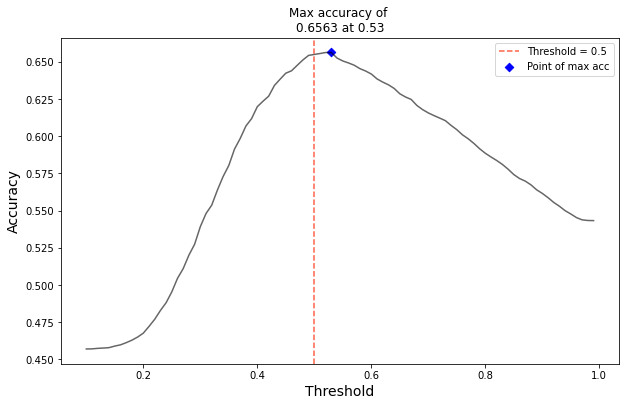

In [190]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.set_xlabel('Threshold', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.plot(threshold_list, accuracy_list, color = 'black', alpha = 0.6)
ax.axvline(x=0.5, color = 'tomato', linestyle = '--', label = 'Threshold = 0.5')
ax.scatter(x = 0.53, y = 0.6563, marker = 'D', c = 'blue', label = 'Point of max acc')
ax.set_title('Max accuracy of \n{} at 0.53'.format(round(max(accuracy_list), 4)))

plt.legend()

plt.show()

For saving some time, let's save the data used so far as csv files
to be easier to use from now on

In [191]:
X.to_csv('X.csv', index = False)
X_ohe.to_csv('X_ohe.csv', index = False)
df2018_clf['above_below_avg_cn'].to_csv('y_cn.csv', index = False)
df2018_clf['above_below_avg_ch'].to_csv('y_ch.csv', index = False)
df2018_clf['above_below_avg_lc'].to_csv('y_lc.csv', index = False)
df2018_clf['above_below_avg_mt'].to_csv('y_mt.csv', index = False)
df2018_clf['above_below_avg_red'].to_csv('y_red.csv', index = False)

In [192]:
## And the label encoder for future use
dump(le, open('label_encoder.pkl', 'wb'))

In [28]:
X = pd.read_csv('X.csv')
X_ohe = pd.read_csv('X_ohe.csv')
y_cn = pd.read_csv('y_cn.csv')

<a id='rf'></a>

## Random Forest Classifier

Now let's analyse how RandomForest performs on the dataset

In [194]:
# Creating the classifier and testing it for the X (no OHE used)

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, train_size = 0.8, random_state = 0)

clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

Accuracy: 0.6507 
[[6071 1740]
 [3282 3285]]


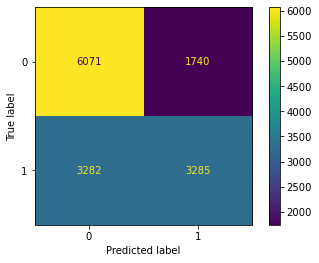

In [195]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 4))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf_rf, X = X_test)

plt.show()

Okay, so the model is not as good as I expected. Let's investigate what happens if it is used
X_ohe instead. Secondly, let's check whether it is possible to improve the model's performance
by dropping some components.

In [196]:
# Creating the classifier and testing it for the X_ohe

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_cn, train_size = 0.8, random_state = 0)

clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

Accuracy: 0.6561 
[[6113 1698]
 [3246 3321]]


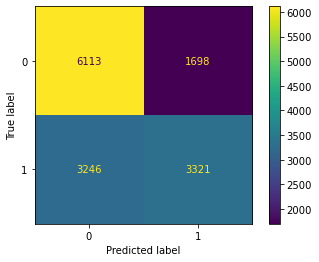

In [197]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 4))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf_rf, X = X_test)

plt.show()

Interestingly, it is not seen a huge drawback as expected. Probably that occurs
due to removing of the city collumn, which could have put the model into troubles
if it was OHE. Let's see if removing some features one could increase the model's
performance.

In [198]:
## Rerunning the model with the original features X (instead of X_ohe)

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, train_size = 0.8, random_state = 0)

clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

In [214]:
## The feature importance function

def plot_feature_importance(model, X, n_cols = 20):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns[:n_cols])),
                               columns=['Value','Feature'])

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Features', fontsize = 16)
    plt.tight_layout()
    plt.show()
    return feature_imp['Value'], feature_imp['Feature']

<a id='rf_feat_imp'></a>

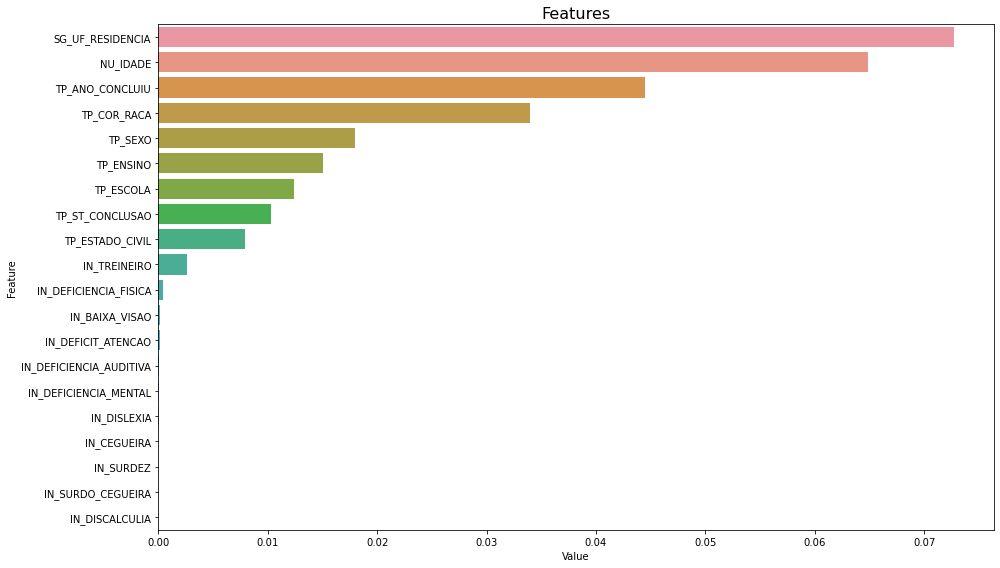

In [199]:
plot_feature_importance(clf_rf, X)

## Partial discussion

In a non-understandable way random forest is choosing some features which doesn't seem to
be relevant (below *IN_TREINEIRO*). It has been strongly expected that social information
would play a more relevant role within all this. Let's take a closer look into some of
these features distribution and how they are split into their classes.

In [200]:
columns_in = X.columns[9:60]

print('All the in columns')
print(' ')
print(columns_in)

All the in columns
 
Index(['IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA',
       'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF',
       'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR',
       'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18',
       'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS',
       'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS',
       'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA', 'IN_GUIA_INTERPRETE',
       'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO',
       'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO',
       'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MEDIDOR_GLICOSE',
       'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA',
       'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL',

In [201]:
def ratio_classes(col):
    var_1 = X[col].sum()
    var_0 = len(X[col]) - var_1
    total = len(X[col])
    percent_0 = round(100*var_0/total, 2)
    percent_1 = round(100*var_1/total, 2)
    print('In {} the class-0 represent {} percent'.format(col, percent_0))
    print('In {} the class-1 represent {} percent'.format(col, percent_1))
    print(' ')

for col in columns_in:
    ratio_classes(col)

In IN_TREINEIRO the class-0 represent 96.16 percent
In IN_TREINEIRO the class-1 represent 3.84 percent
 
In IN_BAIXA_VISAO the class-0 represent 99.92 percent
In IN_BAIXA_VISAO the class-1 represent 0.08 percent
 
In IN_CEGUEIRA the class-0 represent 100.0 percent
In IN_CEGUEIRA the class-1 represent 0.0 percent
 
In IN_SURDEZ the class-0 represent 100.0 percent
In IN_SURDEZ the class-1 represent 0.0 percent
 
In IN_DEFICIENCIA_AUDITIVA the class-0 represent 99.98 percent
In IN_DEFICIENCIA_AUDITIVA the class-1 represent 0.02 percent
 
In IN_SURDO_CEGUEIRA the class-0 represent 100.0 percent
In IN_SURDO_CEGUEIRA the class-1 represent 0.0 percent
 
In IN_DEFICIENCIA_FISICA the class-0 represent 99.8 percent
In IN_DEFICIENCIA_FISICA the class-1 represent 0.2 percent
 
In IN_DEFICIENCIA_MENTAL the class-0 represent 99.98 percent
In IN_DEFICIENCIA_MENTAL the class-1 represent 0.02 percent
 
In IN_DEFICIT_ATENCAO the class-0 represent 99.93 percent
In IN_DEFICIT_ATENCAO the class-1 represent

That was quite good! As suspected! These info bring no information for the model.
The only one which *could* bring something would be *IN_TREINEIRO*, however, this
also poorly splits the data in this tree-based models. So, as a first shot, let's keep
*IN_TREINEIRO* and drop the remaining ones.

In [202]:
columns_in = columns_in[1:]
columns_in

Index(['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
       'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
       'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO',
       'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR',
       'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_LEITURA_LABIAL',
       'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
       'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
       'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO',
       'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR',
       'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN',
       'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL',
       'IN_SALA_ESPECIAL', 'IN_SALA_ACOMPAN

In [203]:
## where 'wo' stands for without

X_wo_in = X.drop(columns = columns_in).copy()

X_wo_in.columns

Index(['SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'TP_ENSINO', 'IN_TREINEIRO', 'TP_LINGUA', 'Q001', 'Q002', 'Q003',
       'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027', 'capital_or_not',
       'single_or_not'],
      dtype='object')

In [204]:
## Rerunning the model with the original features X (instead of X_ohe)

X_train, X_test, y_train, y_test = train_test_split(X_wo_in, y_cn, train_size = 0.8, random_state = 0)

clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

Cross validation over 5 folds: 0.6468
Accuracy for the training set: 0.9997 
Accuracy for the testing set: 0.6526 
[[6011 1800]
 [3195 3372]]


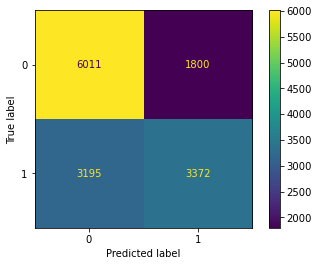

In [205]:
acc_cv = round(cross_val_score(clf_lr, X_train, y_train, cv = 5).mean(), 4)
acc_train = round(accuracy_score(y_train, clf_rf.predict(X_train)), 4)
acc_test = round(accuracy_score(y_test, y_pred), 4)

print('Cross validation over 5 folds: {}'.format(acc_cv))
print('Accuracy for the training set: {} '.format(acc_train)) 
print('Accuracy for the testing set: {} '.format(acc_test))
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf_rf, X = X_test)

plt.show()

<a id='rf_feat_imp2'></a>

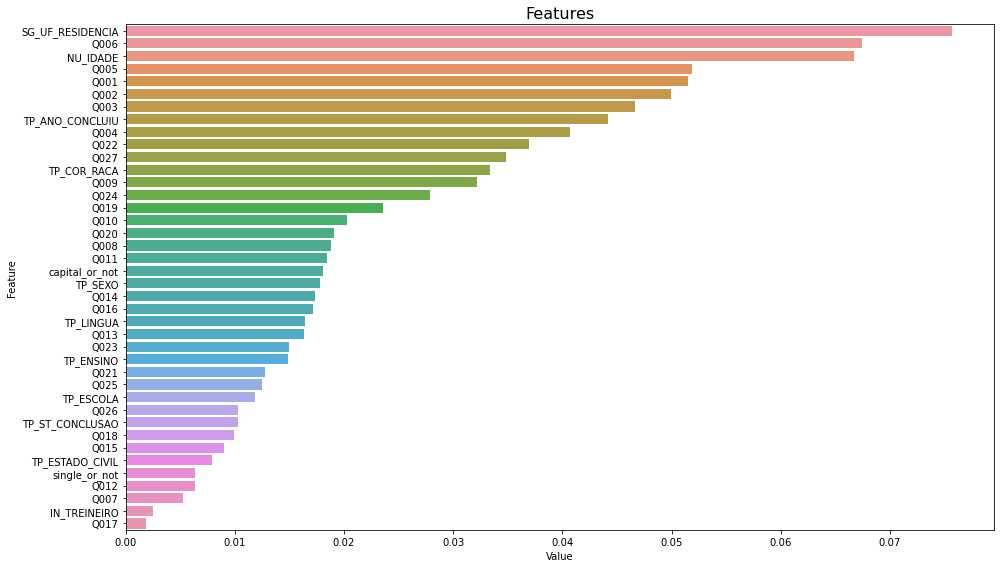

In [218]:
values, features = plot_feature_importance(clf_rf, X_wo_in, n_cols = 40)

In [230]:
#print(features[-10:])
#print(values[-10:].sum())
def perc_relevance(n):
    feat = features[-n:]
    vals_sum = round(100*values[-n:].sum(), 2)
    print('With the best {} features, one explains {} percent of the model '.format(n, vals_sum))

perc_relevance(30)

With the best 30 features, one explains 93.03 percent of the model 


## Partial discussion 2

It is indeed a good progress: we have removed a huge number of irrelevant features
and the model went from an accuracy of 0.6507 to an accuracy of 0.6526. Although
being just a small improvement, we got rid of a **lot of** irrelevant features.


## Next steps

Sure that trying to go beyond the simple model might lead to an accuracy improvement,
however we are simply using a RF classifier for the prediction, we aim to use later on
XGBoost, LightGBM and CatBoost, whereas the first seems to have some problems with large
amount of features the other two seems to perform better with large amount of categorical
features and one might spend a good amount of time on that.

In [231]:
## Saving the new X

X_wo_in.to_csv('X_wo_in.csv', index = False)

<a id='xgb_classifier'></a>
## XGboost classifier

Let's start analyzing other classifiers and see how they perform
on our dataset prior to any hyperparameter tunning

In [4]:
X_wo_in = pd.read_csv('X_wo_in.csv')
y_cn = pd.read_csv('y_cn.csv')

X_train, X_test, y_train, y_test = train_test_split(X_wo_in, y_cn, train_size = 0.8, random_state = 0)

[13:25:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:25:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:25:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:25:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

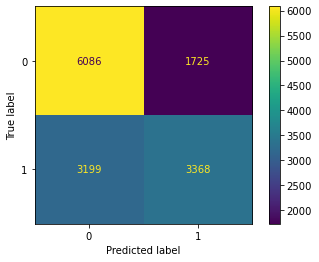

In [17]:
clf_xgb = XGBClassifier(objective = 'binary:logistic', seed = 0)

clf_xgb.fit(X_train, y_train, verbose = False,
            eval_metric = ['error', 'auc'],
            eval_set = [(X_test, y_test)],
            early_stopping_rounds = 10)

y_pred = clf_xgb.predict(X_test)

## Calculating the accuracy score

acc_cv = round(cross_val_score(clf_xgb, X_train, y_train, cv = 5).mean(), 4)
acc_train = round(accuracy_score(y_train, clf_xgb.predict(X_train)), 4)
acc_test = round(accuracy_score(y_test, y_pred), 4)
print(' ')
print('Cross validation over 5 folds: {}'.format(acc_cv))
print('Accuracy for the training set: {} '.format(acc_train)) 
print('Accuracy for the testing set: {} '.format(acc_test))

plot_confusion_matrix(y_true = y_test, estimator = clf_xgb, X = X_test)

plt.show()

Nice, without any parameter tuning it got one percent better.

It is rather common to see improvements of 5% to 10% after
parameter tuning, so we expect to cross the threshold of 70%.

Lets start by looking at the number of trees in our forest

In [6]:
#X_min = X_min2.copy()

er_train = []
er_test = []
n_ests = []

## Setting the feature table and the target into the DMatrix format
#D_train = xgb.DMatrix(X_train, label = y_train)
#D_test = xgb.DMatrix(X_test, label = y_test)

## Some parameters that won't be updated
eval_metric = ['auc', 'error']
eval_set = [(X_train, y_train), (X_test, y_test)]

for n_estimators in range(20, 420, 20):
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        max_depth = 2, n_estimators = n_estimators)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    error_train = round(1 - accuracy_score(y_train, y_pred_train), 2)
    error_test = round(1 - accuracy_score(y_test, y_pred_test), 2)
    
    er_train.append(error_train)
    er_test.append(error_test)
    n_ests.append(n_estimators)
    print(n_estimators)
    

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400


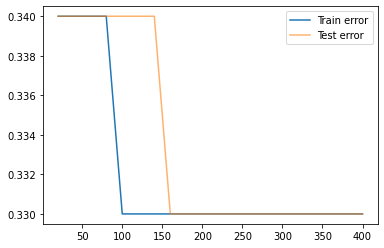

In [7]:
fig, ax = plt.subplots()

ax.plot(n_ests, er_train, label = 'Train error')
ax.plot(n_ests, er_test, label = 'Test error', alpha = 0.6)

plt.legend()
plt.show()

Let's them keep 180 trees and we will tune the other parameters below

### Max depth optimization

In [22]:
for max_depth in [2, 5, 10, 20]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        verbosity = 0,
                        n_estimators = 180,
                        max_depth = max_depth)

    clf.fit(X_train, y_train, verbose = 0,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 18)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    print (' ')
    print ('Accuracy analysis for {} levels in the tree:'.format(max_depth))
    
    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)
    
    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print ('----------------------------------------------')
    print (' ')

 
Accuracy analysis for 2 levels in the tree:
 
Cross validation over 5 folds: 0.6628
Accuracy for the training set: 0.6661 
Accuracy for the testing set: 0.6647 
----------------------------------------------
 
 
Accuracy analysis for 5 levels in the tree:
 
Cross validation over 5 folds: 0.6522
Accuracy for the training set: 0.6729 
Accuracy for the testing set: 0.6639 
----------------------------------------------
 
 
Accuracy analysis for 10 levels in the tree:
 
Cross validation over 5 folds: 0.6315
Accuracy for the training set: 0.7388 
Accuracy for the testing set: 0.656 
----------------------------------------------
 
 
Accuracy analysis for 20 levels in the tree:
 
Cross validation over 5 folds: 0.6294
Accuracy for the training set: 0.9559 
Accuracy for the testing set: 0.6255 
----------------------------------------------
 


A tree with only two levels is performing better than the one with 5 levels.
However, let's check it out if there is a higher performance in between.

In [23]:
for max_depth in [2, 3, 4, 5]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        verbosity = 0,
                        n_estimators = 180,
                        max_depth = max_depth)

    clf.fit(X_train, y_train, verbose = 0,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 18)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    
    print (' ')
    print ('Accuracy analysis for {} levels in the tree:'.format(max_depth))
    
    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)
    
    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print ('----------------------------------------------')
    print (' ')

 
Accuracy analysis for 2 levels in the tree:
 
Cross validation over 5 folds: 0.6628
Accuracy for the training set: 0.6661 
Accuracy for the testing set: 0.6647 
----------------------------------------------
 
 
Accuracy analysis for 3 levels in the tree:
 
Cross validation over 5 folds: 0.6606
Accuracy for the training set: 0.6626 
Accuracy for the testing set: 0.6652 
----------------------------------------------
 
 
Accuracy analysis for 4 levels in the tree:
 
Cross validation over 5 folds: 0.6592
Accuracy for the training set: 0.6745 
Accuracy for the testing set: 0.6654 
----------------------------------------------
 
 
Accuracy analysis for 5 levels in the tree:
 
Cross validation over 5 folds: 0.6522
Accuracy for the training set: 0.6729 
Accuracy for the testing set: 0.6639 
----------------------------------------------
 


Interestingly we clearly observe a beginning of overfitting for max_depth = 10
it becomes astonishing for max_depth = 20, where the accuracy on the training
set goes up, to 0.9559, and the accuracy on the testing set drops to 0.6255.
After a closer look to what happens in between the levels 2 and 5, one observes
that a max_depth of 4 is the best. Let's stick with it then.
### Learning rate - eta - optimization

In [25]:
for eta  in [0.01, 0.05, 0.1, 0.3]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = 120, max_depth = 4,
                        eta = eta)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 12)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    print (' ')
    print ('Accuracy analysis for eta = {} '.format(eta))
    
    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)
    
    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print ('----------------------------------------------')
    #0.6654 

 
Accuracy analysis for eta = 0.01 
 
Cross validation over 5 folds: 0.6473
Accuracy for the training set: 0.6386 
Accuracy for the testing set: 0.6392 
----------------------------------------------
 
 
Accuracy analysis for eta = 0.05 
 
Cross validation over 5 folds: 0.6591
Accuracy for the training set: 0.6657 
Accuracy for the testing set: 0.6643 
----------------------------------------------
 
 
Accuracy analysis for eta = 0.1 
 
Cross validation over 5 folds: 0.6614
Accuracy for the training set: 0.6646 
Accuracy for the testing set: 0.6652 
----------------------------------------------
 
 
Accuracy analysis for eta = 0.3 
 
Cross validation over 5 folds: 0.6592
Accuracy for the training set: 0.6745 
Accuracy for the testing set: 0.6654 
----------------------------------------------
 


We observe that the highest accuracy on the testing set is for eta = 0.3.
Since we observe an increasing trend from 0.01 to 0.3, we observe what happens
is that we are not reaching the saddle point/minimum of the gradient boosting.
This fact is well know, we need, when changing the learning rate, also change
the number of trees (which is essentially how many steps we take to go towards
the minimum). Let's see what happens when we increase the number of estimators/trees

As expected we have surpassed the previous values. let's make analyze
the number of trees which better fit our model

In [ ]:
n_trees = []
ac_test = []

for n_tree in np.linspace(100, 2000, 20):
    n_tree = int(n_tree)

    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = n_tree, max_depth = 4,
                        eta = 0.01)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 120)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print ('Accuracy analysis for {} trees and eta = 0.01'.format(n_tree))

    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)
    
    n_trees.append(n_tree)
    ac_test.append(acc_test)

    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print ('----------------------------------------------')

Accuracy analysis for 100 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6465
Accuracy for the training set: 0.6482 
Accuracy for the testing set: 0.6479 
----------------------------------------------
Accuracy analysis for 200 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6515
Accuracy for the training set: 0.6546 
Accuracy for the testing set: 0.6537 
----------------------------------------------
Accuracy analysis for 300 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6547
Accuracy for the training set: 0.6585 
Accuracy for the testing set: 0.6584 
----------------------------------------------
Accuracy analysis for 400 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6567
Accuracy for the training set: 0.6607 
Accuracy for the testing set: 0.6615 
----------------------------------------------
Accuracy analysis for 500 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6578
Accuracy for the training set: 0.664 
Accuracy for the testing set: 0

We observe that it apparently reached the bottom of the gradient descendent/boosting process
for 700 trees. If we increase the "size" of our step one might be there in less steps (consequently,
less trees). However, there is also the chance that one overshoots the minimum and overpass it.

Let's see what happens in the case of eta = 0.1

In [9]:
eval_metric = ['error', 'auc']
eval_set = [(X_train, y_train), (X_test, y_test)]

clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                    verbosity = 0,
                    n_estimators = 500, max_depth = 4,
                    eta = 0.1)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = eval_metric,
        eval_set = eval_set,
        early_stopping_rounds = 50)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print ('Accuracy analysis for 1200 trees and eta = 0.1')

acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
acc_train = round(accuracy_score(y_train, y_pred_train), 4)
acc_test = round(accuracy_score(y_test, y_pred_test), 4)

print(' ')
print('Cross validation over 5 folds: {}'.format(acc_cv))
print('Accuracy for the training set: {} '.format(acc_train)) 
print('Accuracy for the testing set: {} '.format(acc_test))
print ('----------------------------------------------')

Accuracy analysis for 1200 trees and eta = 0.1
 
Cross validation over 5 folds: 0.6602
Accuracy for the training set: 0.6774 
Accuracy for the testing set: 0.6648 
----------------------------------------------


In [10]:
## Trying eta = 0.05

eval_metric = ['error', 'auc']
eval_set = [(X_train, y_train), (X_test, y_test)]

clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                    verbosity = 0,
                    n_estimators = 500, max_depth = 4,
                    eta = 0.05)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = eval_metric,
        eval_set = eval_set,
        early_stopping_rounds = 50)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print ('Accuracy analysis for 1200 trees and eta = 0.05')

acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
acc_train = round(accuracy_score(y_train, y_pred_train), 4)
acc_test = round(accuracy_score(y_test, y_pred_test), 4)

print(' ')
print('Cross validation over 5 folds: {}'.format(acc_cv))
print('Accuracy for the training set: {} '.format(acc_train)) 
print('Accuracy for the testing set: {} '.format(acc_test))
print ('----------------------------------------------')

Accuracy analysis for 1200 trees and eta = 0.05
 
Cross validation over 5 folds: 0.6615
Accuracy for the training set: 0.6774 
Accuracy for the testing set: 0.6664 
----------------------------------------------


Wow! So we managed to get even further in our accuracy, as a last test, let's see what
happens if we set n_estimators = 1000 for instance 

#### P.S.: It was used 500 trees not 1200 as it states

In [11]:
## Trying eta = 0.05

eval_metric = ['error', 'auc']
eval_set = [(X_train, y_train), (X_test, y_test)]

clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                    verbosity = 0,
                    n_estimators = 1000, max_depth = 4,
                    eta = 0.05)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = eval_metric,
        eval_set = eval_set,
        early_stopping_rounds = 50)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print ('Accuracy analysis for 1000 trees and eta = 0.05')

acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
acc_train = round(accuracy_score(y_train, y_pred_train), 4)
acc_test = round(accuracy_score(y_test, y_pred_test), 4)

print(' ')
print('Cross validation over 5 folds: {}'.format(acc_cv))
print('Accuracy for the training set: {} '.format(acc_train)) 
print('Accuracy for the testing set: {} '.format(acc_test))
print ('----------------------------------------------')

Accuracy analysis for 1000 trees and eta = 0.05
 
Cross validation over 5 folds: 0.6608
Accuracy for the training set: 0.6774 
Accuracy for the testing set: 0.6664 
----------------------------------------------


Consequently we will stick with the values of eta = 0.05 and n_estimators = 500

### Bagging parameters

XGBoost alows us to perform bagging as one of the features to avoid overfitting.
Although it seems we are not doing so, let's investigate if we can achieve a
better accuracy by changing the percentage of rows chosen for the boosting
and the percentage of features used

In [13]:
for subsample  in [0.7, 0.75, 0.8, 0.85, 0.9]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = 500, max_depth = 4, eta = 0.05,
                        subsample = subsample)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    print ('Accuracy considering a subsample of {}'.format(subsample))

    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)

    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print ('----------------------------------------------') 

Accuracy considering a subsample of 0.7
 
Cross validation over 5 folds: 0.6619
Accuracy for the training set: 0.6752 
Accuracy for the testing set: 0.6646 
----------------------------------------------
Accuracy considering a subsample of 0.75
 
Cross validation over 5 folds: 0.6626
Accuracy for the training set: 0.6764 
Accuracy for the testing set: 0.665 
----------------------------------------------
Accuracy considering a subsample of 0.8
 
Cross validation over 5 folds: 0.6629
Accuracy for the training set: 0.6757 
Accuracy for the testing set: 0.665 
----------------------------------------------
Accuracy considering a subsample of 0.85
 
Cross validation over 5 folds: 0.662
Accuracy for the training set: 0.6788 
Accuracy for the testing set: 0.6641 
----------------------------------------------
Accuracy considering a subsample of 0.9
 
Cross validation over 5 folds: 0.6624
Accuracy for the training set: 0.6786 
Accuracy for the testing set: 0.6641 
----------------------------

In [14]:
## Percentage of features

for colsample_bytree  in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = 500, max_depth = 4, eta = 0.05,
                        colsample_bytree = colsample_bytree
                        )

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 12)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 2)
    acc_test = round(accuracy_score(y_test, y_pred_test), 2)
    
    print ('Accuracy considering a subsample of {}'.format(subsample))

    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)

    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print ('----------------------------------------------')

Accuracy considering a subsample of 0.9
 
Cross validation over 5 folds: 0.6619
Accuracy for the training set: 0.6733 
Accuracy for the testing set: 0.6641 
----------------------------------------------
Accuracy considering a subsample of 0.9
 
Cross validation over 5 folds: 0.6615
Accuracy for the training set: 0.6745 
Accuracy for the testing set: 0.6658 
----------------------------------------------
Accuracy considering a subsample of 0.9
 
Cross validation over 5 folds: 0.6614
Accuracy for the training set: 0.6727 
Accuracy for the testing set: 0.6656 
----------------------------------------------
Accuracy considering a subsample of 0.9
 
Cross validation over 5 folds: 0.6629
Accuracy for the training set: 0.6724 
Accuracy for the testing set: 0.665 
----------------------------------------------
Accuracy considering a subsample of 0.9
 
Cross validation over 5 folds: 0.6613
Accuracy for the training set: 0.6751 
Accuracy for the testing set: 0.6652 
----------------------------

### Conclusion about xgboost

So the best XGBoost model that we have obtained reached an accuracy of 0.6658 and it was the following

In [ ]:
eval_metric = ['error', 'auc']
eval_set = [(X_train, y_train), (X_test, y_test)]

clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                    verbosity = 0,
                    n_estimators = 500, max_depth = 4,
                    eta = 0.05)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = eval_metric,
        eval_set = eval_set,
        early_stopping_rounds = 50)

Comparing to the baseline model that we have worked on, using Logistic Regression, 
we  have an improvement of $|0.655 - 0.6664|/0.655 \simeq 0.017$ which corresponds
an improvement of 1.7%.

Since it was a rather small improvement, let's see what we can do using LightGBM

<a id='lgbm'></a>

## LightGBM Classifier

In [3]:
X_wo_in = pd.read_csv('X_wo_in.csv')
y_cn = pd.read_csv('y_cn.csv')

X_train, X_test, y_train, y_test = train_test_split(X_wo_in, y_cn, train_size = 0.8, random_state = 0)

## part of the model's information

eval_metric = ['error', 'auc']
eval_set = [(X_train, y_train), (X_test, y_test)]

In [41]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0)

clf = lgb.LGBMClassifier(objective = 'binary', seed = 0, verbosity = -1)

clf.fit(X_train, y_train,
        eval_metric = eval_metric,
        eval_set = eval_set,
        early_stopping_rounds = 50, verbose = False)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
acc_train = round(accuracy_score(y_train, y_pred_train), 4)
acc_test = round(accuracy_score(y_test, y_pred_test), 4)

print(' ')
print('Cross validation over 5 folds: {}'.format(acc_cv))
print('Accuracy for the training set: {} '.format(acc_train)) 
print('Accuracy for the testing set: {} '.format(acc_test))
print('----------------------------------------------')

 
Cross validation over 5 folds: 0.6619
Accuracy for the training set: 0.6864 
Accuracy for the testing set: 0.6623 
----------------------------------------------


Schön! This is quite good. Using the baseline model of LightGBM we observe
that we obtained the best score in testing set and a not much higher score
in the training set, which might be a spot light in the end of this dark tunnel.
Let's perform the same tests as before and see what happens.

Basic accuracy in **Log. Reg.** : 0.6550

Basic accuracy in **XGBoost**   : 0.6575

Basic accuracy in **LightGBM**  : 0.6623

<a id='fi_lgbm'></a>
### Feature importance

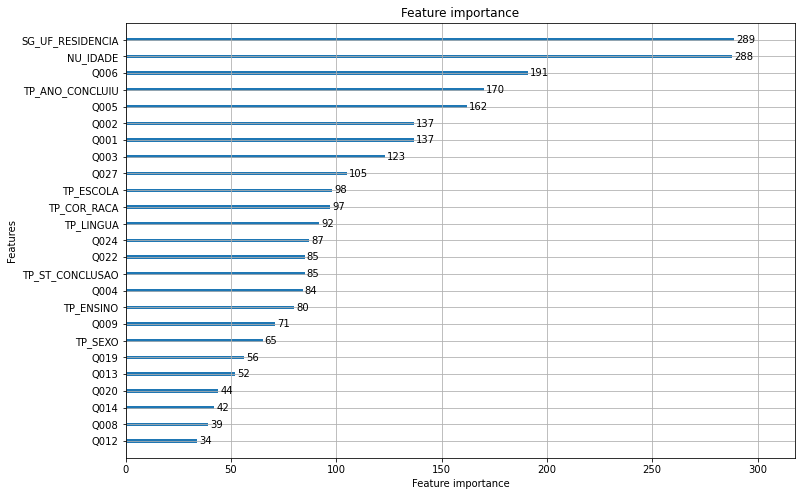

In [24]:
feature_importance = lgb.plot_importance(clf, max_num_features = 25, figsize = (12, 8))

plt.show()

So we can drammatically reduce the number of feature (95 to 25 features)
and keep the same accuracy.

### Hyperparameter tunning in LightGBM

Despite of all similarities, LightGBM has a a significant
difference when compared to XGBoost: whereas the latter
is based in the is a tree growth based algorithm and the
main ways to control the complexity of the tree is through max_depth,
that is not directly true for the former. LightGBM bases itself
on the number of leaves, which might be connect to how shallow/deeper
is the tree, but **not necessarily**. For further information check the
[documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [38]:
for num_leaves in [2, 4, 8, 32, 64, 128, 256, 512, 1024, 2056]:
    clf = lgb.LGBMClassifier(objective = 'binary', seed = 0, verbosity = -1,
                            num_leaves = num_leaves)

    clf.fit(X_train, y_train,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50, verbose = False)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)

    print('Accuracy test for LightGBM considering {} leaves'.format(num_leaves))
    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print('----------------------------------------------')

# 0.6623

Accuracy test for LightGBM considering 2 leaves
 
Cross validation over 5 folds: 0.6545
Accuracy for the training set: 0.6552 
Accuracy for the testing set: 0.6561 
----------------------------------------------
Accuracy test for LightGBM considering 4 leaves
 
Cross validation over 5 folds: 0.6589
Accuracy for the training set: 0.6607 
Accuracy for the testing set: 0.6619 
----------------------------------------------
Accuracy test for LightGBM considering 8 leaves
 
Cross validation over 5 folds: 0.6603
Accuracy for the training set: 0.666 
Accuracy for the testing set: 0.6633 
----------------------------------------------
Accuracy test for LightGBM considering 32 leaves
 
Cross validation over 5 folds: 0.6615
Accuracy for the training set: 0.6733 
Accuracy for the testing set: 0.6646 
----------------------------------------------
Accuracy test for LightGBM considering 64 leaves
 
Cross validation over 5 folds: 0.6599
Accuracy for the training set: 0.6877 
Accuracy for the testing

Let's analyze what happens around the 32 leaves, trying to make a fine tune of it.

In [47]:
for num_leaves in np.arange(32, 43, 2):
    clf = lgb.LGBMClassifier(objective = 'binary', seed = 0, verbosity = -1,
                            num_leaves = num_leaves)

    clf.fit(X_train, y_train,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50, verbose = False)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)

    print('Accuracy test for LightGBM considering {} leaves'.format(num_leaves))
    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print('----------------------------------------------')

# 0.6646 

Accuracy test for LightGBM considering 32 leaves
 
Cross validation over 5 folds: 0.6615
Accuracy for the training set: 0.6733 
Accuracy for the testing set: 0.6646 
----------------------------------------------
Accuracy test for LightGBM considering 34 leaves
 
Cross validation over 5 folds: 0.6619
Accuracy for the training set: 0.6881 
Accuracy for the testing set: 0.6611 
----------------------------------------------
Accuracy test for LightGBM considering 36 leaves
 
Cross validation over 5 folds: 0.6613
Accuracy for the training set: 0.6904 
Accuracy for the testing set: 0.6628 
----------------------------------------------
Accuracy test for LightGBM considering 38 leaves
 
Cross validation over 5 folds: 0.6603
Accuracy for the training set: 0.6766 
Accuracy for the testing set: 0.6639 
----------------------------------------------
Accuracy test for LightGBM considering 40 leaves
 
Cross validation over 5 folds: 0.6607
Accuracy for the training set: 0.6934 
Accuracy for the tes

Let's then stick with num_leaves = 32


### Minimum data in leaf tuning
This tells us about the minimum amount of data to be in in a leaf. This
is quite helpful in some cases because it helps to avoid trees to grow
too deeply. However, in our case it is not that helpful, since we are
basically not overfitting. But let's play with some values.

In [53]:
for min_child_samples in [20, 100, 1000]:# default = 20
    clf = lgb.LGBMClassifier(objective = 'binary', seed = 0, verbosity = -1,
                            num_leaves = 32,
                            min_data_in_leaf = min_child_samples
                            )

    clf.fit(X_train, y_train,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50, verbose = False)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)

    print('Accuracy test for minimum data to split'.format(min_child_samples))
    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print('----------------------------------------------')

# 0.6646

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Accuracy test for minimum data to split
 
Cross validation over 5 folds: 0.6615
Accuracy for the training set: 0.6733 
Accuracy for the testing set: 0.6646 
----------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samp

As we expected it played no role in our model's improvement. Let's try other parameters

### Learning rate and number of iterations

In [57]:
num_iterations = 1000

for eta in [0.01, 0.05, 0.1, 0.3]:
    clf = lgb.LGBMClassifier(objective = 'binary', seed = 0, verbosity = -1,
                             num_leaves = 32, num_iterations = num_iterations,
                             learning_rate = eta
                             )

    clf.fit(X_train, y_train,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50, verbose = False)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
    acc_train = round(accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(accuracy_score(y_test, y_pred_test), 4)

    print('Accuracy test for 1000 trees and eta = {}'.format(eta))
    print(' ')
    print('Cross validation over 5 folds: {}'.format(acc_cv))
    print('Accuracy for the training set: {} '.format(acc_train)) 
    print('Accuracy for the testing set: {} '.format(acc_test))
    print('----------------------------------------------')

# 0.6646

Accuracy test for 1000 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6618
Accuracy for the training set: 0.6704 
Accuracy for the testing set: 0.663 
----------------------------------------------
Accuracy test for 1000 trees and eta = 0.05
 
Cross validation over 5 folds: 0.6547
Accuracy for the training set: 0.6774 
Accuracy for the testing set: 0.6652 
----------------------------------------------
Accuracy test for 1000 trees and eta = 0.1
 
Cross validation over 5 folds: 0.6502
Accuracy for the training set: 0.6733 
Accuracy for the testing set: 0.6646 
----------------------------------------------
Accuracy test for 1000 trees and eta = 0.3
 
Cross validation over 5 folds: 0.6285
Accuracy for the training set: 0.6691 
Accuracy for the testing set: 0.6623 
----------------------------------------------


Schön! We managed to improve it a little bit!!! However, we
might be able to improve it even more. Let's see what happens if
we increase the number of trees (for eta = 0.01 we didn't reach the
the values associated to 0.05 nor 0.1. To what concerns eta = 0.3,
we can drop it now, since we see that it is overshooting the minimum.

In [5]:
for num_iterations in [1000, 1500]:
    for eta in [0.01, 0.05, 0.1]:
        clf = lgb.LGBMClassifier(objective = 'binary', seed = 0, verbosity = -1,
                                 num_leaves = 32, num_iterations = num_iterations,
                                 learning_rate = eta
                                 )

        clf.fit(X_train, y_train,
                eval_metric = eval_metric,
                eval_set = eval_set,
                early_stopping_rounds = int(num_iterations/10), verbose = False)

        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
        acc_train = round(accuracy_score(y_train, y_pred_train), 4)
        acc_test = round(accuracy_score(y_test, y_pred_test), 4)

        print('Accuracy test for {} trees and eta = {}'.format(num_iterations, eta))
        print(' ')
        print('Cross validation over 5 folds: {}'.format(acc_cv))
        print('Accuracy for the training set: {} '.format(acc_train)) 
        print('Accuracy for the testing set: {} '.format(acc_test))
        print('----------------------------------------------')

# 0.6652 

Accuracy test for 1000 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6618
Accuracy for the training set: 0.6767 
Accuracy for the testing set: 0.6646 
----------------------------------------------
Accuracy test for 1000 trees and eta = 0.05
 
Cross validation over 5 folds: 0.6547
Accuracy for the training set: 0.6774 
Accuracy for the testing set: 0.6652 
----------------------------------------------
Accuracy test for 1000 trees and eta = 0.1
 
Cross validation over 5 folds: 0.6502
Accuracy for the training set: 0.6733 
Accuracy for the testing set: 0.6646 
----------------------------------------------
Accuracy test for 1500 trees and eta = 0.01
 
Cross validation over 5 folds: 0.6618
Accuracy for the training set: 0.6767 
Accuracy for the testing set: 0.6646 
----------------------------------------------
Accuracy test for 1500 trees and eta = 0.05
 
Cross validation over 5 folds: 0.653
Accuracy for the training set: 0.6856 
Accuracy for the testing set: 0.6643 
---------

We observe that the best accuracy was achieved for 1000 trees
and learning rate of 0.05.

<a id='partial_conclusion'></a>

# Partial conclusion about what has been achieved so far

### About the models

For this problem specifically we observed that the baseline models, all of them,
started with accuracy above 60%, but we didn't manage to increase its accuracy
much beyond that, even after a detailed parameter tunning in lightgbm and xgboost.
A proper feature engineering might be necessary if one wants to improve its accuracy
and cross the 70% border. An idea to be implemented later is the creation of a 
"social status parameter", which is a composition of several parameters in a single one.


However, before embarking in this journey, let's do some stuff before:

1) Let's analyze the accuracy curve of our model and see how if is possible, by changing
the threshold, to improve the model's accuracy.

2) Understand better whether this small improvement can have any impact or not.

In [4]:
num_iterations = 1000
eta = 0.05

clf = lgb.LGBMClassifier(objective = 'binary', seed = 0, verbosity = -1,
                         num_leaves = 32, num_iterations = num_iterations,
                         learning_rate = eta
                         )

clf.fit(X_train, y_train,
        eval_metric = eval_metric,
        eval_set = eval_set,
        early_stopping_rounds = int(num_iterations/10), verbose = False)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

acc_cv = round(cross_val_score(clf, X_train, y_train, cv = 5).mean(), 4)
acc_train = round(accuracy_score(y_train, y_pred_train), 4)
acc_test = round(accuracy_score(y_test, y_pred_test), 4)

print('Accuracy test for {} trees and eta = {}'.format(num_iterations, eta))
print(' ')
print('Cross validation over 5 folds: {}'.format(acc_cv))
print('Accuracy for the training set: {} '.format(acc_train)) 
print('Accuracy for the testing set: {} '.format(acc_test))
print('----------------------------------------------')

# 0.6652 

Accuracy test for 1000 trees and eta = 0.05
 
Cross validation over 5 folds: 0.6547
Accuracy for the training set: 0.6774 
Accuracy for the testing set: 0.6652 
----------------------------------------------


In [9]:
threshold_list = []
accuracy_list  = []
for threshold in np.arange(0.1, 1, 0.01):
    threshold = round(threshold, 2)
    predicted_proba = clf.predict_proba(X_test)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')

    accuracy = accuracy_score(y_test, predicted)
    
    threshold_list.append(threshold)
    accuracy_list.append(accuracy)

<a id='diff_th_lgbm'></a>

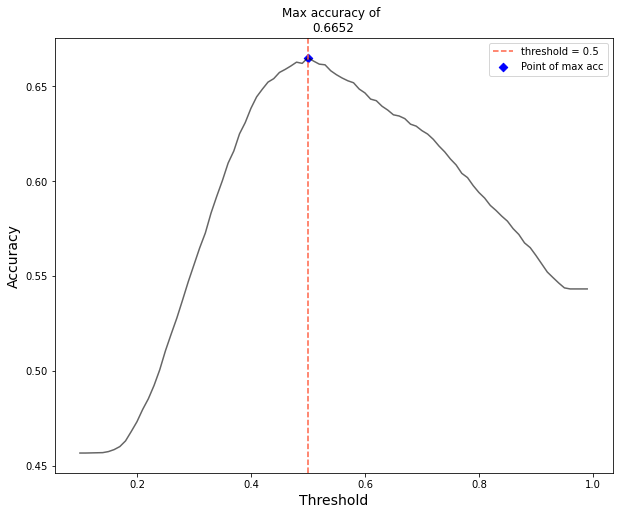

In [15]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.set_xlabel('Threshold', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.plot(threshold_list, accuracy_list, color = 'black', alpha = 0.6)
ax.axvline(x=0.5, color = 'tomato', linestyle = '--', label = 'threshold = 0.5')
ax.set_title('Max accuracy of \n{}'.format(round(max(accuracy_list), 4)))
ax.scatter(x = 0.5, y = max(accuracy_list), marker = 'D', c = 'blue', label = 'Point of max acc')

plt.legend()

plt.show()

So we observe that indeed this was the better split that we could have done.
Let's then check whether this small improvement has any impact or not.
<a id='final_conc'></a>
## Final conclusion about the natural science classification problem

This small improvement is related to students all over the country and it has
for sure an impact on the brazilian economy (and we will analyze how much
that could help soon).

Nowadays we are facing a lot of problems regarding people which do not trust scientific evidences.
Let's suppose that a future president wants to improve the performance of the students in natural
science exams, because he/she thinks that is quite relevant that people trust in science, otherwise
there will be more people thinking that is okay to not take the vaccines, not wearing masks during
the pandemic, etc... The first move of this new president is to create reinforcement classes for
the students which have a greater chance to score below the mean of 2018 and the president wants
to know how much teachers he would need to hire for natural sciences (i.e., Physics Chemistry and
Biology) (this is a hypothetical situation, it is most likely that the solutions for science
education in Brazil are others (although the number of teachers might be an issue as well)).

Firstly, lets analyze the following: *TP_DEPENDENCIA_ADM_ESC* contains the kind of school
that the applicant came from. Let's see if indeed the majority are coming from public schools

Number of applicants which didn't reply: TP_DEPENDENCIA_ADM_ESC    722625
dtype: int64


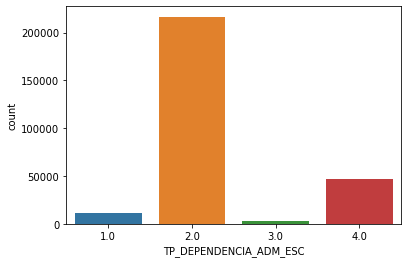

In [16]:
df_tp_escola = pd.read_csv('DADOS/MICRODADOS_ENEM_2018.csv', usecols = ['TP_DEPENDENCIA_ADM_ESC'],
                           nrows = 1000000, sep = ';', encoding = 'ISO-8859-1')


print ("Number of applicants which didn't reply: {}".format(df_tp_escola.isna().sum()))

sns.countplot(df_tp_escola.TP_DEPENDENCIA_ADM_ESC)
plt.show()

##We observe that among those which replied, the vast majority are from public schools

In [17]:
public = len(df_tp_escola[df_tp_escola.TP_DEPENDENCIA_ADM_ESC == 2] )
total = df_tp_escola.TP_DEPENDENCIA_ADM_ESC.notna().sum()

percentage = round(100*public/total, 2)

print('Percentage of students in public school: {}'.format(percentage))

## Let's extrapolate this value for all the applicants.

Percentage of students in public school: 78.02


### Identifying the amount of students from public schools

Since the average of applicants in enem last year was around [5 millions](https://veja.abril.com.br/educacao/com-5-milhoes-de-inscritos-confirmados-enem-segue-tendencia-de-queda/)
we are going to assume that $78\pm 7.8\%$ were from public schools. Being
conservative regarding these numbers, let's take the lower bound of $71.2\%$.
Therefore, 3.560.000 students were from public schools and are paid by the government.

### Identifying the amount of Physics, Chemistry and Biology teachers necessary

The classes in public high schools have the average of $30.5$ students per class, according
to the [Ministery of Education](http://portal.mec.gov.br/component/tags/tag/media.).
Since to complete the studies one needs three years, it means that one student is going
to have nine teachers in natural sciences along the high school.

As we have $3.560.000$ students from public schools applying to ENEM, these students, when
grouped together, represent $3.560.000/30.5 \simeq 116.721$ classes, such that each of
these classes during the high school have had $116.721*9 = 1.050.492$ teachers in natural
science. However, the relation is not one teacher per class. Physics and Chemistry for
example have three classes during the week, while Biology has two. Let's take as fixed
value three classes a week. Since most teachers have $20$ hours of in-class working hours,
it means that each of them have around $7$ classes per year. Therefore, we need to divide
the number $1.050.492/7 \simeq 150.070$ and the **number of teachers** to train the students
go through the public high schools is $\simeq 150.070$.


%%%Ensino Médio: R\% 2.872,00

### Project of a governmental plan to improve Science in Brazil

After looking the data, the Federal government observes that there are more students
below the mean rather than above the mean as we show below

In [19]:
above = round(100*y_cn.above_below_avg_cn.sum()/len(y_cn), 2)
below = 100 - above

n_above = y_cn.above_below_avg_cn.sum()
n_below = len(y_cn) - n_above

print('In Brazil {}% of the students are above the mean, whereas {}% are below the mean in Natural Sciences'.format(above, below))

In Brazil 46.06% of the students are above the mean, whereas 53.94% are below the mean in Natural Sciences


In [20]:
print(n_above)
print(n_below)

33113
38777


<a id='final_conc'></a>

The government then decides to develop a plan to have all
of the students above the mean in Natural Sciences of 2018. For doing so,
they decided to hire more teachers for reinforcement classes for the three
natural sciences subjects.

According to [Agencia Brasil website](https://agenciabrasil.ebc.com.br/educacao/noticia/2020-10/redes-publicas-de-ensino-registram-361-milhoes-matriculas) there was 6.220.817
students enrolled in public high schools. Assuming a equal division among
the different levels, one has $2073606$ students in the first year of the
high school. Taking the national value where $53.94\%$ of the students are
below the mean, it corresponds to $1118503$ students belonging to this class
(below the mean of 2018). The former model had an accuracy of $65.50\%$ whereas
the best has an accuracy of $66.62\%$. This information tells us that the latter
can identify **up to** $13422$ more students than the former correctly that are
below the mean. However, this is not the only impact though.

Whether it is considered the opposite limit (identification of this $1.2%$
are in the class 1) one can prevent up to $13422$ to be missclassified
in the class 0 and it could save some money for the Brazilian government.
Let's estimate how much money we are talking about.

One student needs nine teachers throughout his/her course in high school,
consequently one has $9\cdot13422 = 120798$ teachers. Each class has, in
average, $30.5$ students, it means that one would need $3961$ teachers.
Each teacher is responsible for approximatelly 7 classes, which lead us to
$3961/7 = 566$ teachers to be hired. The mean salary of teachers in public
high schools in Brazilian reais is [2886.24](http://portal.mec.gov.br/component/tags/tag/32666),
which corresponds to an anual income of $13\cdot2886.24 = 37521.12$, for
all the teachers one would have $566\cdot37521.12 = 21236953.92$, a little
over $21$ millions in Brazilian reais per year (and we are considering only
the liquid salary). Over one cycle (three years) one group of students
will go through the entire highschool. Another group will have two years
in the high school (when the first group go from the first to the second year)
and a third one will be starting. Therefore, in three years we have
the expense of $6\cdot 21236953.92 \simeq 128$ millions.

For the federal government, according to the [UNICAMP website](https://www.unicamp.br/unicamp/coronavirus/quanto-custa), $128\cdot10^6$ is equivalent to:

- Test almost 1.9 million Brazilian people for COVID-19;
- Implantation of a little over 700 ICU rooms;
- For attending 1000 ICU rooms for COVID-patients, it costs $207000R\$$ in medical supplies.
One could mantain these ICU for almost two years.

Also, related to the education per se, it is informed that during 2020 [$143.3$](https://g1.globo.com/educacao/noticia/2021/02/21/ministerio-da-educacao-nao-gasta-o-dinheiro-que-tem-disponivel-e-sofre-reducao-de-recursos-em-2020-aponta-relatorio.ghtml)
billions Brazilian reais was reserved to the education. Accordingly to our value, that is approximatelly
$0.01\%$ of the total income used in the entire education in the country.

Another interesting example regarding education, according to [this news](https://g1.globo.com/educacao/noticia/2019/09/02/capes-deixa-de-oferecer-5613-bolsas-a-partir-deste-mes-e-preve-economia-de-r-544-milhoes-em-4-anos.ghtml)
the federal funding agency was planning to cancel 5.613 scholarships for PhD
and Master researchers and that would allow them to save 544 millions in Brazilian reais
in four years, which corresponds to 136 millions in one year. Our calculation basic
improvement shows a saving of 32 millions per year, which corresponds to roughly $25\%$
of this value.

<a id='diff_path'></a>

# Different analysis that could have been done

As it has been seen throughout this work, although we have aimed in the accuracy of the model
we were able to have an idea of what this **small** improvement can produce regarding real values and,
interestingly, for some factors small improvements can return sizable profits.

Also, depending on the situation of the company/institution accuracy might not be the most
relevant to be checked. For example, considere the following confusion_matrix and the two cases
below:

<img src="https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg" alt="Confusion Matrix" style="height: 300px; width:400px;"/>


**Case (I):** The government is really focused on improving those students which
are below the mean, even if it costs making wrong predictions about those which are
above the mean. In this case, the quantity that one is interested in maximizing is

$$\frac{TN}{TN+FP}\,,$$
which is the recall for the negative class (or specificity).

On the other hand, we have the case (II) below.

**Case (II):** Although the government really wants to improve the grades
in natural sciences it really wants to avoid making wrong predictions
and including those students which are above the mean. In this case the
pertinent quantity is

$$\frac{TN}{TN + FN}\,,$$
which is the precision for the negative class of the model.
